In [1]:
# imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import struct
from array import array
from os.path  import join
import random


# started from this video: https://www.youtube.com/watch?v=w8yWXqWQYmU&t=579s

In [2]:
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [3]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline

#
# Set file paths based on added MNIST Datasets
#
input_path = './MNIST_ORG/'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# x_train and x_test are the images in a list of 28x28 arrays
# y_train and y_test are the number it should represent as a list of integers
# training data is 60000 labelled images, test is 10000 images

m = 60000
n = 784

leakyReLUalpha = 0.2
ELUalpha = 0.2

l = 10000
# need to reshape the 28x28 arrays into one 784x1 array, since the input to the matrix multiplciation has to be a 1xn matrix, not nxn
x_train = np.array(x_train).reshape(m ,n).T / 255
x_test = np.array(x_test).reshape(l,n).T / 255
y_train = np.array(y_train).reshape(m)
y_test = np.array(y_test).reshape(l)

# x_train = x_train[,0:10000]
# y_train = y_train[0:10000,]

#
# Show some random training and test images
#
# images_2_show = []
# titles_2_show = []
# for i in range(0, 10):
#     r = random.randint(1, 60000)
#     images_2_show.append(x_train[r])
#     titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))
#
# for i in range(0, 5):
#     r = random.randint(1, 10000)
#     images_2_show.append(x_test[r])
#     titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))
#
# show_images(images_2_show, titles_2_show)

In [11]:

# print(len(x_train))
# print(len(y_train))
# print(len(x_test))
# print(len(y_test))
#
# print(len(x_train[0]))
# print(y_train[0])
# print(len(x_test[0][0]))
# print(y_test[0])

print(x_train.shape) # confirmed right shape as in video
print(y_train.shape)
print(y_train[0:20])

(784, 60000)
(60000,)
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [12]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [4]:
"""Activation and Normalization Function Definitions"""

def ReLU(Z):
    # print("Before ReLU: ",Z[0:10,0:10])
    return np.maximum(0,Z)
def deriv_ReLU(Z):
    return Z > 0


def sigmoid(Z):
    # print("Before ReLU: ",Z[0:10,0:10])
    return 1/(1 + np.exp(-Z))
def deriv_sigmoid(Z):
    exp = np.exp(-Z)
    return exp/(1 + 2 * exp + exp**2)


def arctan(Z):
    return np.arctan(Z)
def deriv_arctan(Z):
    return 1/(1+Z**2)


def LeakyReLU(Z):
    # print("Before ReLU: ",Z[0:10,0:10])
    return np.where(Z > 0, Z, leakyReLUalpha * Z)
def deriv_LeakyReLU(Z):
    return np.where(Z > 0, 1, leakyReLUalpha)


def ELU(Z):
    return np.where(Z > 0, Z, ELUalpha * (np.exp(Z) - 1))
def deriv_ELU(Z):
    return np.where(Z > 0, 1, ELUalpha * np.exp(Z))


def GELU(Z):
    return 0.5*Z*(1 +np.tanh(np.sqrt(2 / np.pi) * ( Z + 0.0447 * Z**3)))
def deriv_GELU(Z):
    return (np.tanh((0.0447* Z**3+Z)*np.sqrt(2 / np.pi)) + 1)/2 + (Z + 0.1341 * Z**3) / np.cosh((0.0447* Z**3+Z) * np.sqrt(2/np.pi))**2 / np.sqrt(2 * np.pi)


def swish(Z):
    return Z / (1 + np.exp(-Z))
def deriv_swish(Z):
    exp = np.exp(-Z)
    return (1 + exp + Z * exp)/(1 + 2 * exp + exp**2)

def softPlus(Z):
    return np.log(1 + np.exp(Z))
def deriv_softPlus(Z):
    exp = np.exp(Z)
    return exp/(1+exp)



def softMax(Z):
    L = Z - np.max(Z, axis=0, keepdims=True)
    expL = np.exp(L)
    return expL / expL.sum(axis=0, keepdims=True)

def Squaring(Z):
    Z = Z / (np.max(np.abs(Z)) + 1e-12)
    Z2 = Z**2
    return Z2 / (np.sum(Z2) + 1e-12)
    # return Z**2 / np.sum(Z**2)

def ScaleMaxMin(Z):
    min = np.min(Z)
    max = np.max(Z)
    if max - min < 1e-12:
        return Z
    return (Z - min) / (max - min)

def ScaleMeanStd(Z):
    mean = np.mean(Z)
    std = np.std(Z)
    std = max(std, 1e-12)
    return (Z - mean) / std

def logSoftMax(Z):
    Zmax = np.max(Z)
    return Z - (Zmax + np.log(np.sum(np.exp(Z - Zmax))))


def sparseMax(Z):
    # written by chatGPT
    K, N = Z.shape
    Zs = np.sort(Z, axis=0)[::-1]
    Zs_cumsum = np.cumsum(Zs, axis=0)
    k = np.arange(1, K + 1).reshape(-1, 1)
    cond = Zs - (Zs_cumsum - 1) / k > 0
    rho = cond.sum(axis=0)
    rho = np.maximum(rho, 1)
    tau = (Zs_cumsum[rho - 1, np.arange(N)] - 1) / rho
    return np.maximum(Z - tau, 0)

# def entmax15(z, n_iter=50):
#     # bisection to find tau
#     # written by chatGPT
#     lo, hi = z.min()-1, z.max()
#     for _ in range(n_iter):
#         tau = (lo + hi) / 2
#         p = np.maximum(0.5*z - tau, 0)**2
#         if p.sum() > 1:
#             lo = tau
#         else:
#             hi = tau
#     return p

In [5]:
def init_params():
    W1 = (np.random.rand(10, n) - 0.5)*np.sqrt(2/n)
    b1 = (np.random.rand(10, 1) - 0.5)/100
    W2 = (np.random.rand(10, 10) - 0.5)*np.sqrt(1/10)
    b2 = (np.random.rand(10, 1) - 0.5)/100
    # print(W1,b1, W2, b2)
    return W1, b1, W2, b2

def forward_prop(W1, b1, W2, b2, X, weight_Z1, weight_Z2):
    # print("Forward Prop beginning:")
    # print("X: ",X[0:784,0:10])
    Z1 = W1.dot(X) + b1
    # print("Z1 shape: ", Z1.shape)
    # print(X.shape)
    A1 = weight_Z1(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = weight_Z2(Z2)
    return Z1, A1, Z2, A2

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y


def back_prop(Z1, A1, A2, W2, X, Y, deriv_weight_Z1):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * deriv_weight_Z1(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    # dW1Norm = np.linalg.norm(dW1)
    # W1Norm = np.linalg.norm(W1)
    # print("Norms before updating: W1", W1Norm, ", dW1: ", dW1Norm)
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    return W1, b1, W2, b2

In [6]:

def get_predictions(A):
    return np.argmax(A, 0)

def get_accuracy(predictions, Y):
    # print(predictions[10:30], Y[10:30])
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, iterations, alpha, weight_Z1, weight_Z2, deriv_weight_Z1):
    W1, b1, W2, b2 = init_params()
    accuracy = [[],[]]
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X, weight_Z1, weight_Z2)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, A2, W2, X, Y, deriv_weight_Z1)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        prediction = get_accuracy(get_predictions(A2), Y)
        accuracy[0].append(i)
        accuracy[1].append(prediction)
        if ((i % 50 == 0) | (i == iterations - 1)):
            print("iteration: ", i, ", Accuracy: ", "{:.4f}".format(prediction), ", Z1 denominator: ", "{:.2e}".format(np.sum(np.exp(Z1))))
    return W1, b1, W2, b2, accuracy

In [7]:
_,_,_,_,accuracy = gradient_descent(x_train, y_train, 40, 0.1, ReLU, ScaleMaxMin, deriv_ReLU)
#[softMax, Squaring, ScaleMaxMin, ScaleMeanStd, logSoftMax, sparseMax]

iteratio:  0 , Accuracy:  0.1000 , Z1 denominator:  6.45e+05
iteratio:  39 , Accuracy:  0.0975 , Z1 denominator:  inf


/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3570573490.py:19: RuntimeWarning: overflow encountered in exp
  print("iteratio: ", i, ", Accuracy: ", "{:.4f}".format(prediction), ", Z1 denominator: ", "{:.2e}".format(np.sum(np.exp(Z1))))


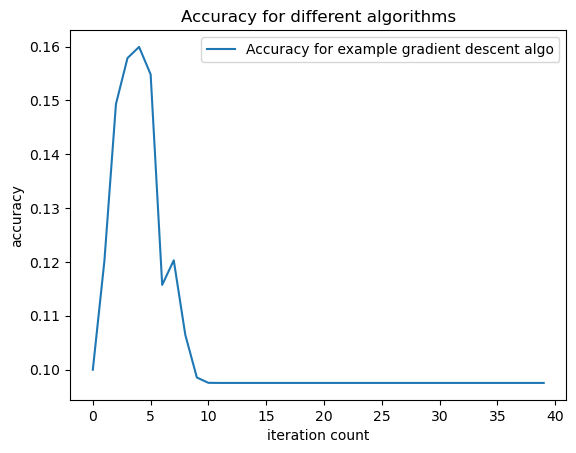

In [8]:

plt.plot(accuracy[0], accuracy[1], label = "Accuracy for example gradient descent algo")
plt.xlabel("iteration count")
plt.ylabel("accuracy")
plt.title("Accuracy for different algorithms")
plt.legend()

## Permutations to test:
### Different Z1 activation functions (and associated derivatives):
- ReLU
- Sigmoid
- arctan
- leaky ReLU (additional parameter)
- parametric ReLU (More complicated to implement)
- Exponential LU (ELU)
- Scaled ELU
- Gaussian Error LU (GELU)
- Swish
- Softplus
-
### Different Z2 normalizations:
- numerically stable softmax (what I needed to make it work)
- softmax given in the video didn't work, worth it to test again
- $\frac{Z^2}{\sum Z^2}$ ?
- $\frac{Z - \min(Z)}{\max(Z) - \min(Z)}$ ?
- $\frac{Z - \mu}{\sigma}$ ?
- logsoftmax
- sparsemax
- entmax
### $\alpha$
- 0.1 works fairly well
- see if 0.01 or lower is more stable
- see how high we can push learning rate (0.5)?
-


In [74]:

# A = np.zeros((len(ActivationFunctions), len(NormalizationFunctions), len(alphas)))
# A[0,0,0]

0.0

In [9]:
ActivationFunctions = [ReLU, sigmoid, arctan, LeakyReLU, ELU, GELU, swish, softPlus]
ActivationDerivatives = [deriv_ReLU, deriv_sigmoid, deriv_arctan, deriv_LeakyReLU, deriv_ELU, deriv_GELU, deriv_swish, deriv_softPlus]
NormalizationFunctions = [softMax, Squaring, ScaleMaxMin, ScaleMeanStd, logSoftMax, sparseMax]
alphas = [0.001, 0.01, 0.1, 0.3, 0.5, 0.8]
A = np.empty((len(ActivationFunctions), len(NormalizationFunctions), len(alphas)), dtype=object)

numIterations = 10

for i in range(len(ActivationFunctions)):
    for j in range(len(NormalizationFunctions)):
        for k in range(len(alphas)):
            print("Activation fn: " + ActivationFunctions[i].__name__ + ", Norm fn: " + NormalizationFunctions[j].__name__ + ", a : " + str(alphas[k]))
            _,_,_,_,accuracy = gradient_descent(x_train, y_train, numIterations, alphas[k], ActivationFunctions[i], NormalizationFunctions[j], ActivationDerivatives[i])
            A[i,j,k] = accuracy

Activation fn: ReLU, Norm fn: softMax, a : 0.001
iteratio:  0 , Accuracy:  0.0821 , Z1 denominator:  5.98e+05
iteratio:  9 , Accuracy:  0.0840 , Z1 denominator:  5.98e+05
Activation fn: ReLU, Norm fn: softMax, a : 0.01
iteratio:  0 , Accuracy:  0.0936 , Z1 denominator:  5.76e+05
iteratio:  9 , Accuracy:  0.1062 , Z1 denominator:  5.82e+05
Activation fn: ReLU, Norm fn: softMax, a : 0.1
iteratio:  0 , Accuracy:  0.0374 , Z1 denominator:  6.15e+05
iteratio:  9 , Accuracy:  0.2931 , Z1 denominator:  6.49e+05
Activation fn: ReLU, Norm fn: softMax, a : 0.3
iteratio:  0 , Accuracy:  0.0847 , Z1 denominator:  6.16e+05
iteratio:  9 , Accuracy:  0.4534 , Z1 denominator:  1.10e+06
Activation fn: ReLU, Norm fn: softMax, a : 0.5
iteratio:  0 , Accuracy:  0.0995 , Z1 denominator:  6.33e+05
iteratio:  9 , Accuracy:  0.5088 , Z1 denominator:  1.92e+06
Activation fn: ReLU, Norm fn: softMax, a : 0.8
iteratio:  0 , Accuracy:  0.1323 , Z1 denominator:  6.01e+05
iteratio:  9 , Accuracy:  0.5115 , Z1 denomi

/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3570573490.py:19: RuntimeWarning: overflow encountered in exp
  print("iteratio: ", i, ", Accuracy: ", "{:.4f}".format(prediction), ", Z1 denominator: ", "{:.2e}".format(np.sum(np.exp(Z1))))
/Users/markzhitnitsky/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  inf
Activation fn: ReLU, Norm fn: ScaleMaxMin, a : 0.001
iteratio:  0 , Accuracy:  0.0990 , Z1 denominator:  6.18e+05
iteratio:  9 , Accuracy:  0.0988 , Z1 denominator:  6.15e+05
Activation fn: ReLU, Norm fn: ScaleMaxMin, a : 0.01
iteratio:  0 , Accuracy:  0.1038 , Z1 denominator:  6.01e+05
iteratio:  9 , Accuracy:  0.1206 , Z1 denominator:  6.59e+05
Activation fn: ReLU, Norm fn: ScaleMaxMin, a : 0.1
iteratio:  0 , Accuracy:  0.0888 , Z1 denominator:  5.81e+05
iteratio:  9 , Accuracy:  0.0975 , Z1 denominator:  1.02e+74
Activation fn: ReLU, Norm fn: ScaleMaxMin, a : 0.3
iteratio:  0 , Accuracy:  0.0926 , Z1 denominator:  6.07e+05
iteratio:  9 , Accuracy:  0.0975 , Z1 denominator:  inf
Activation fn: ReLU, Norm fn: ScaleMaxMin, a : 0.5
iteratio:  0 , Accuracy:  0.1123 , Z1 denominator:  5.86e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  inf
Activation fn: ReLU, Norm fn: ScaleMaxMin, a : 0.8
iteratio:  0 , Accuracy:  0.1442 , 

/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:83: RuntimeWarning: invalid value encountered in subtract
  return Z - (Zmax + np.log(np.sum(np.exp(Z - Zmax))))


iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  nan
Activation fn: ReLU, Norm fn: logSoftMax, a : 0.3
iteratio:  0 , Accuracy:  0.0882 , Z1 denominator:  5.97e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  nan
Activation fn: ReLU, Norm fn: logSoftMax, a : 0.5
iteratio:  0 , Accuracy:  0.1085 , Z1 denominator:  5.97e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  nan
Activation fn: ReLU, Norm fn: logSoftMax, a : 0.8
iteratio:  0 , Accuracy:  0.0767 , Z1 denominator:  5.90e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  nan
Activation fn: ReLU, Norm fn: sparseMax, a : 0.001
iteratio:  0 , Accuracy:  0.0502 , Z1 denominator:  5.76e+05
iteratio:  9 , Accuracy:  0.0524 , Z1 denominator:  5.74e+05
Activation fn: ReLU, Norm fn: sparseMax, a : 0.01
iteratio:  0 , Accuracy:  0.1139 , Z1 denominator:  6.09e+05
iteratio:  9 , Accuracy:  0.1388 , Z1 denominator:  5.93e+05
Activation fn: ReLU, Norm fn: sparseMax, a : 0.1
iteratio:  0 , Accuracy:  0.1071 , Z1 denominator

/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:32: RuntimeWarning: overflow encountered in exp
  return np.where(Z > 0, Z, ELUalpha * (np.exp(Z) - 1))
/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:34: RuntimeWarning: overflow encountered in exp
  return np.where(Z > 0, 1, ELUalpha * np.exp(Z))


iteratio:  9 , Accuracy:  0.0975 , Z1 denominator:  inf
Activation fn: ELU, Norm fn: ScaleMaxMin, a : 0.001
iteratio:  0 , Accuracy:  0.1215 , Z1 denominator:  6.12e+05
iteratio:  9 , Accuracy:  0.1226 , Z1 denominator:  6.11e+05
Activation fn: ELU, Norm fn: ScaleMaxMin, a : 0.01
iteratio:  0 , Accuracy:  0.0872 , Z1 denominator:  6.07e+05
iteratio:  9 , Accuracy:  0.0948 , Z1 denominator:  6.51e+05
Activation fn: ELU, Norm fn: ScaleMaxMin, a : 0.1
iteratio:  0 , Accuracy:  0.0835 , Z1 denominator:  6.17e+05
iteratio:  9 , Accuracy:  0.0975 , Z1 denominator:  inf
Activation fn: ELU, Norm fn: ScaleMaxMin, a : 0.3
iteratio:  0 , Accuracy:  0.1515 , Z1 denominator:  6.26e+05
iteratio:  9 , Accuracy:  0.0975 , Z1 denominator:  inf
Activation fn: ELU, Norm fn: ScaleMaxMin, a : 0.5
iteratio:  0 , Accuracy:  0.0935 , Z1 denominator:  5.96e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  inf
Activation fn: ELU, Norm fn: ScaleMaxMin, a : 0.8
iteratio:  0 , Accuracy:  0.0611 , Z1 denomina

/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:40: RuntimeWarning: overflow encountered in cosh
  return (np.tanh((0.0447* Z**3+Z)*np.sqrt(2 / np.pi)) + 1)/2 + (Z + 0.1341 * Z**3) / np.cosh((0.0447* Z**3+Z) * np.sqrt(2/np.pi))**2 / np.sqrt(2 * np.pi)
/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:40: RuntimeWarning: overflow encountered in square
  return (np.tanh((0.0447* Z**3+Z)*np.sqrt(2 / np.pi)) + 1)/2 + (Z + 0.1341 * Z**3) / np.cosh((0.0447* Z**3+Z) * np.sqrt(2/np.pi))**2 / np.sqrt(2 * np.pi)


iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  7.17e+30
Activation fn: GELU, Norm fn: Squaring, a : 0.5
iteratio:  0 , Accuracy:  0.0959 , Z1 denominator:  5.99e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  2.97e+142
Activation fn: GELU, Norm fn: Squaring, a : 0.8
iteratio:  0 , Accuracy:  0.0599 , Z1 denominator:  6.26e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  inf
Activation fn: GELU, Norm fn: ScaleMaxMin, a : 0.001
iteratio:  0 , Accuracy:  0.0927 , Z1 denominator:  5.86e+05
iteratio:  9 , Accuracy:  0.0915 , Z1 denominator:  5.86e+05
Activation fn: GELU, Norm fn: ScaleMaxMin, a : 0.01
iteratio:  0 , Accuracy:  0.0932 , Z1 denominator:  5.99e+05
iteratio:  9 , Accuracy:  0.1043 , Z1 denominator:  5.49e+05
Activation fn: GELU, Norm fn: ScaleMaxMin, a : 0.1
iteratio:  0 , Accuracy:  0.0657 , Z1 denominator:  6.16e+05
iteratio:  9 , Accuracy:  0.0981 , Z1 denominator:  3.17e+20
Activation fn: GELU, Norm fn: ScaleMaxMin, a : 0.3
iteratio:  0 , Accuracy:  0.08

/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:38: RuntimeWarning: overflow encountered in power
  return 0.5*Z*(1 +np.tanh(np.sqrt(2 / np.pi) * ( Z + 0.0447 * Z**3)))
/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:40: RuntimeWarning: overflow encountered in power
  return (np.tanh((0.0447* Z**3+Z)*np.sqrt(2 / np.pi)) + 1)/2 + (Z + 0.1341 * Z**3) / np.cosh((0.0447* Z**3+Z) * np.sqrt(2/np.pi))**2 / np.sqrt(2 * np.pi)
/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:40: RuntimeWarning: invalid value encountered in divide
  return (np.tanh((0.0447* Z**3+Z)*np.sqrt(2 / np.pi)) + 1)/2 + (Z + 0.1341 * Z**3) / np.cosh((0.0447* Z**3+Z) * np.sqrt(2/np.pi))**2 / np.sqrt(2 * np.pi)


iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  inf
Activation fn: GELU, Norm fn: logSoftMax, a : 0.1
iteratio:  0 , Accuracy:  0.1025 , Z1 denominator:  5.98e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  nan
Activation fn: GELU, Norm fn: logSoftMax, a : 0.3
iteratio:  0 , Accuracy:  0.1483 , Z1 denominator:  6.02e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  nan
Activation fn: GELU, Norm fn: logSoftMax, a : 0.5
iteratio:  0 , Accuracy:  0.0790 , Z1 denominator:  6.07e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  nan
Activation fn: GELU, Norm fn: logSoftMax, a : 0.8
iteratio:  0 , Accuracy:  0.1243 , Z1 denominator:  6.16e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  nan
Activation fn: GELU, Norm fn: sparseMax, a : 0.001
iteratio:  0 , Accuracy:  0.1348 , Z1 denominator:  6.34e+05
iteratio:  9 , Accuracy:  0.1373 , Z1 denominator:  6.33e+05
Activation fn: GELU, Norm fn: sparseMax, a : 0.01
iteratio:  0 , Accuracy:  0.0963 , Z1 denominator:  5

/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:47: RuntimeWarning: overflow encountered in square
  return (1 + exp + Z * exp)/(1 + 2 * exp + exp**2)
/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:44: RuntimeWarning: overflow encountered in exp
  return Z / (1 + np.exp(-Z))
/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:46: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-Z)
/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:47: RuntimeWarning: overflow encountered in multiply
  return (1 + exp + Z * exp)/(1 + 2 * exp + exp**2)
/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:47: RuntimeWarning: invalid value encountered in add
  return (1 + exp + Z * exp)/(1 + 2 * exp + exp**2)
/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:47: RuntimeWarning: invalid value encountered in divide
  return (1 

iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  nan
Activation fn: swish, Norm fn: ScaleMeanStd, a : 0.8
iteratio:  0 , Accuracy:  0.0669 , Z1 denominator:  5.99e+05
iteratio:  9 , Accuracy:  0.0854 , Z1 denominator:  2.39e+02
Activation fn: swish, Norm fn: logSoftMax, a : 0.001
iteratio:  0 , Accuracy:  0.0842 , Z1 denominator:  6.12e+05
iteratio:  9 , Accuracy:  0.0992 , Z1 denominator:  7.74e+06
Activation fn: swish, Norm fn: logSoftMax, a : 0.01
iteratio:  0 , Accuracy:  0.0764 , Z1 denominator:  6.00e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  inf
Activation fn: swish, Norm fn: logSoftMax, a : 0.1
iteratio:  0 , Accuracy:  0.1100 , Z1 denominator:  5.80e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  nan
Activation fn: swish, Norm fn: logSoftMax, a : 0.3
iteratio:  0 , Accuracy:  0.0982 , Z1 denominator:  6.02e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  nan
Activation fn: swish, Norm fn: logSoftMax, a : 0.5
iteratio:  0 , Accuracy:  0.0876 , Z1 

/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:50: RuntimeWarning: overflow encountered in exp
  return np.log(1 + np.exp(Z))
/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:63: RuntimeWarning: invalid value encountered in divide
  Z = Z / (np.max(np.abs(Z)) + 1e-12)
/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:52: RuntimeWarning: overflow encountered in exp
  exp = np.exp(Z)
/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:53: RuntimeWarning: invalid value encountered in divide
  return exp/(1+exp)


iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  inf
Activation fn: softPlus, Norm fn: Squaring, a : 0.8
iteratio:  0 , Accuracy:  0.0934 , Z1 denominator:  6.00e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  nan
Activation fn: softPlus, Norm fn: ScaleMaxMin, a : 0.001
iteratio:  0 , Accuracy:  0.0975 , Z1 denominator:  5.81e+05
iteratio:  9 , Accuracy:  0.0975 , Z1 denominator:  5.75e+05
Activation fn: softPlus, Norm fn: ScaleMaxMin, a : 0.01
iteratio:  0 , Accuracy:  0.0903 , Z1 denominator:  5.91e+05
iteratio:  9 , Accuracy:  0.0903 , Z1 denominator:  5.58e+05
Activation fn: softPlus, Norm fn: ScaleMaxMin, a : 0.1
iteratio:  0 , Accuracy:  0.1332 , Z1 denominator:  6.06e+05


/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:73: RuntimeWarning: invalid value encountered in subtract
  return (Z - min) / (max - min)
/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:73: RuntimeWarning: invalid value encountered in divide
  return (Z - min) / (max - min)


iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  inf
Activation fn: softPlus, Norm fn: ScaleMaxMin, a : 0.3
iteratio:  0 , Accuracy:  0.0956 , Z1 denominator:  6.01e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  nan
Activation fn: softPlus, Norm fn: ScaleMaxMin, a : 0.5
iteratio:  0 , Accuracy:  0.1041 , Z1 denominator:  6.31e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  nan
Activation fn: softPlus, Norm fn: ScaleMaxMin, a : 0.8
iteratio:  0 , Accuracy:  0.0903 , Z1 denominator:  5.84e+05
iteratio:  9 , Accuracy:  0.0987 , Z1 denominator:  nan
Activation fn: softPlus, Norm fn: ScaleMeanStd, a : 0.001
iteratio:  0 , Accuracy:  0.0986 , Z1 denominator:  6.09e+05
iteratio:  9 , Accuracy:  0.0986 , Z1 denominator:  5.77e+05
Activation fn: softPlus, Norm fn: ScaleMeanStd, a : 0.01
iteratio:  0 , Accuracy:  0.1140 , Z1 denominator:  5.94e+05
iteratio:  9 , Accuracy:  0.0600 , Z1 denominator:  5.19e+05
Activation fn: softPlus, Norm fn: ScaleMeanStd, a : 0.1
iteratio:  0 

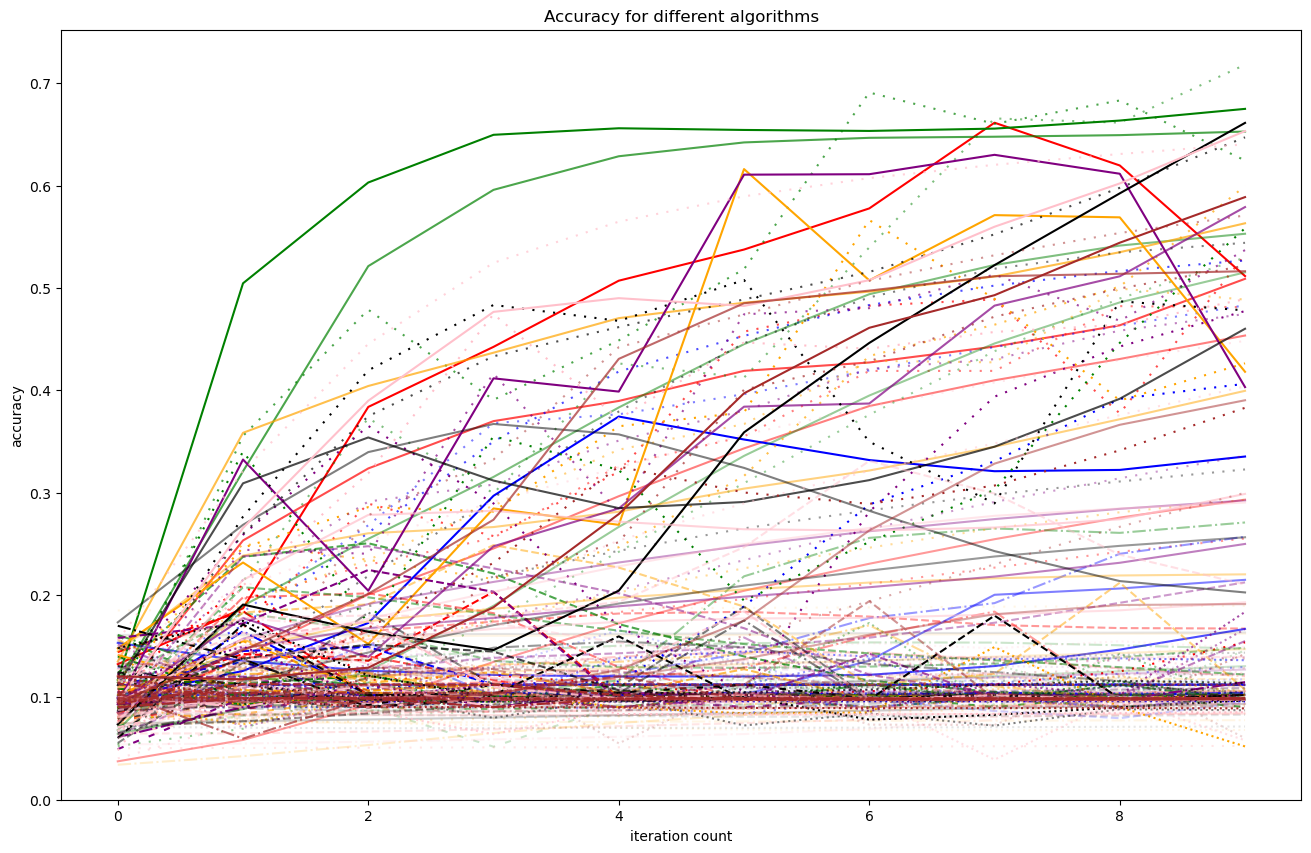

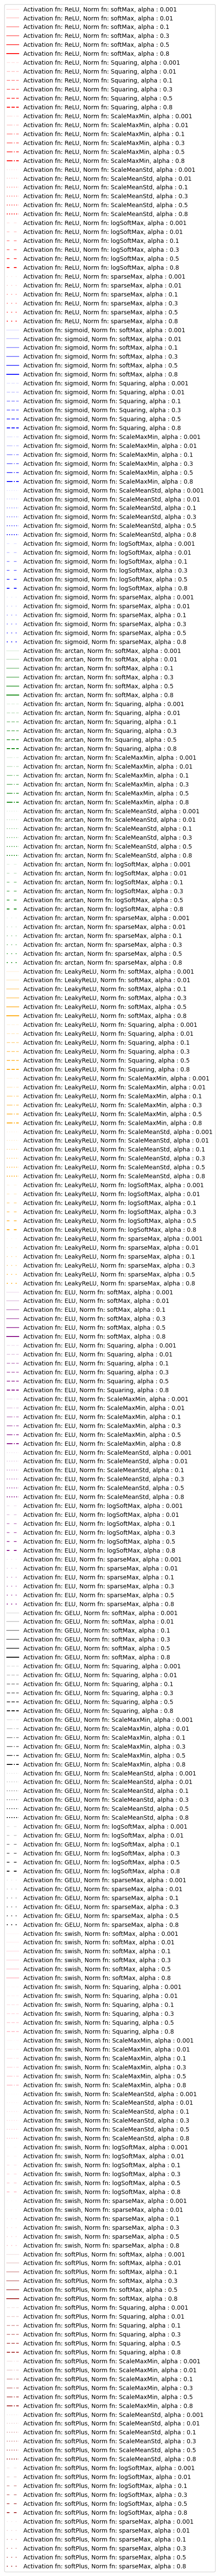

In [11]:
colours = ["red", "blue", "green", "orange", "purple", "black", "pink", "brown"]
lineType = ["-", "--", "-.", ":", (0, (3, 5)), (0, (1, 4))]
brightness = [0.1, 0.2, 0.4, 0.5, 0.7, 1]

# Your main plot
fig, ax = plt.subplots(figsize=(16, 10))  # larger figure

# Separate legend figure

for i in range(len(ActivationFunctions)):
    for j in range(len(NormalizationFunctions)):
        for k in range(len(alphas)):
            accuracy = A[i,j,k]
            ax.plot(accuracy[0], accuracy[1], label = "Activation fn: " + ActivationFunctions[i].__name__ + ", Norm fn: " + NormalizationFunctions[j].__name__ + ", alpha : " + str(alphas[k]), linestyle = lineType[j], color = colours[i], alpha = brightness[k])
plt.xlabel("iteration count")
plt.ylabel("accuracy")
plt.title("Accuracy for different algorithms")
plt.savefig('AccuracyPlot.pdf', dpi=600, bbox_inches='tight')                # vector format, infinitely zoomable


fig_leg = plt.figure()
ax_leg = fig_leg.add_subplot()
ax_leg.axis('off')  # hide axes
ax_leg.legend(*ax.get_legend_handles_labels(), loc='center')
# plt.savefig('figure.png', dpi=300)       # 300 dpi is good for print
plt.savefig('AccuracyLegend.pdf', dpi=600, bbox_inches='tight')                # vector format, infinitely zoomable
plt.show()

### Best Results:
Looking through the graph with every permutation (288 total) and paying attention to the faster growers/highest accuracy after 10 iterations. Done visually with the PDF images.


- Activation fn: arctan, Norm fn: softMax, alpha : 0.8
- Activation fn: arctan, Norm fn: softMax, alpha : 0.5
- Activation fn: arctan, Norm fn: sparseMax, alpha : 0.8
- Activation fn: arctan, Norm fn: sparseMax, alpha : 0.5
- Activation fn: GELU, Norm fn: softMax, alpha : 0.8
- Activation fn: GELU, Norm fn: sparseMax, alpha : 0.5
- Activation fn: swish, Norm fn: sparseMax, alpha : 0.1
- Activation fn: swish, Norm fn: sparseMax, alpha : 0.8
- Activation fn: swish, Norm fn: softMax, alpha 0.8
- Activation fn: ELU, Norm fn: softMax, alphalpha 0.8
- Activation fn: ELU, Norm fn: softMax, alpha 0.8
- Activation fn: ReLU, Norm fn: softMax, alpha : 0.8
- Activation fn: ReLU, Norm fn: softMax, alpha : 0.5
- Activation fn: LeakyReLU, Norm fn: softMax, alpha 0.8 (very fast increase at first then fell off, maybe need value between 0.5 and 0.8)
- Activation fn: LeakyReLU, Norm fn: softMax, alpha 0.5
- Activation fn: LeakyReLU, Norm fn: sparseMax, alpha 0.5
- Activation fn: LeakyReLU, Norm fn: sparseMax, alpha 0.3
- Activation fn: arctan, Norm fn: softMax, alpha : 0.5
- Activation fn: arctan, Norm fn: softMax, alpha : 0.3
- Activation fn: sigmoid, Norm fn: sparseMax, alpha 0.5
- Activation fn: sigmoid, Norm fn: sparseMax, alpha 0.3

In [24]:
# Go through the 3D array and find best performers:

accuracyFnList = []

for i in range(len(ActivationFunctions)):
    for j in range(len(NormalizationFunctions)):
        for k in range(len(alphas)):
            accuracy = A[i,j,k]

            finalAccuracy = accuracy[1][-1]
            accuracyFnList.append((finalAccuracy, ActivationFunctions[i], NormalizationFunctions[j], alphas[k]))


# print(len(accuracyFnList))
# print(A[1,1,1][1][-1])

In [25]:
accuracyFnList.sort(key=lambda x: x[0], reverse=True)
print(accuracyFnList)

[(0.718, <function arctan at 0x11e809940>, <function sparseMax at 0x11e861310>, 0.3), (0.6748666666666666, <function arctan at 0x11e809940>, <function softMax at 0x11e861040>, 0.8), (0.6611666666666667, <function GELU at 0x11e809ca0>, <function softMax at 0x11e861040>, 0.8), (0.6531333333333333, <function swish at 0x11e809dc0>, <function softMax at 0x11e861040>, 0.8), (0.6527166666666666, <function arctan at 0x11e809940>, <function softMax at 0x11e861040>, 0.5), (0.6470833333333333, <function GELU at 0x11e809ca0>, <function sparseMax at 0x11e861310>, 0.5), (0.6402333333333333, <function swish at 0x11e809dc0>, <function sparseMax at 0x11e861310>, 0.5), (0.6244666666666666, <function arctan at 0x11e809940>, <function sparseMax at 0x11e861310>, 0.5), (0.5994833333333334, <function LeakyReLU at 0x11e809a60>, <function sparseMax at 0x11e861310>, 0.5), (0.5886666666666667, <function softPlus at 0x11e809ee0>, <function softMax at 0x11e861040>, 0.8), (0.5789333333333333, <function ELU at 0x11e

In [44]:
BestPerformers = []
for i in range(0,24):
    BestPerformers.append(accuracyFnList[i])

BestPerformers.append((0.0, swish, sparseMax, 0.1))
BestPerformers.append((0.0, swish, sparseMax, 0.8))
BestPerformers.append((0.0, swish, sparseMax, 0.1))
BestPerformers.append((0.0, ELU, sparseMax, 0.8))
BestPerformers.append((0.0, ELU, softMax, 0.8))
BestPerformers.append((0.0, ReLU, softMax, 0.5))
BestPerformers.append((0.0, LeakyReLU, sparseMax, 0.3))
BestPerformers.append((0.0, LeakyReLU, softMax, 0.8))
BestPerformers.append((0.0, sigmoid, sparseMax, 0.3))

print(BestPerformers[0][1])
print(ActivationFunctions.index(BestPerformers[0][1]))
# print(BestPerformers)

<function arctan at 0x11e809940>
2
[(0.718, <function arctan at 0x11e809940>, <function sparseMax at 0x11e861310>, 0.3), (0.6748666666666666, <function arctan at 0x11e809940>, <function softMax at 0x11e861040>, 0.8), (0.6611666666666667, <function GELU at 0x11e809ca0>, <function softMax at 0x11e861040>, 0.8), (0.6531333333333333, <function swish at 0x11e809dc0>, <function softMax at 0x11e861040>, 0.8), (0.6527166666666666, <function arctan at 0x11e809940>, <function softMax at 0x11e861040>, 0.5), (0.6470833333333333, <function GELU at 0x11e809ca0>, <function sparseMax at 0x11e861310>, 0.5), (0.6402333333333333, <function swish at 0x11e809dc0>, <function sparseMax at 0x11e861310>, 0.5), (0.6244666666666666, <function arctan at 0x11e809940>, <function sparseMax at 0x11e861310>, 0.5), (0.5994833333333334, <function LeakyReLU at 0x11e809a60>, <function sparseMax at 0x11e861310>, 0.5), (0.5886666666666667, <function softPlus at 0x11e809ee0>, <function softMax at 0x11e861040>, 0.8), (0.57893

In [45]:
A = np.empty(len(BestPerformers), dtype=object)

numIterations = 30

for i in range (len(BestPerformers)):
    print("Activation fn: " + BestPerformers[i][1].__name__ + ", Norm fn: " + BestPerformers[i][2].__name__ + ", a : " + str(BestPerformers[i][3]))
    _,_,_,_,accuracy = gradient_descent(x_train, y_train, numIterations, BestPerformers[i][3], BestPerformers[i][1], BestPerformers[i][2], ActivationDerivatives[ActivationFunctions.index(BestPerformers[i][1])])
    A[i] = (accuracy, BestPerformers[i][1], BestPerformers[i][2], BestPerformers[i][3])




Activation fn: arctan, Norm fn: sparseMax, a : 0.3
iteratio:  0 , Accuracy:  0.1025 , Z1 denominator:  6.10e+05
iteratio:  29 , Accuracy:  0.7960 , Z1 denominator:  7.29e+05
Activation fn: arctan, Norm fn: softMax, a : 0.8
iteratio:  0 , Accuracy:  0.0754 , Z1 denominator:  6.19e+05
iteratio:  29 , Accuracy:  0.8404 , Z1 denominator:  3.63e+06
Activation fn: GELU, Norm fn: softMax, a : 0.8
iteratio:  0 , Accuracy:  0.0992 , Z1 denominator:  5.75e+05


/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:40: RuntimeWarning: overflow encountered in cosh
  return (np.tanh((0.0447* Z**3+Z)*np.sqrt(2 / np.pi)) + 1)/2 + (Z + 0.1341 * Z**3) / np.cosh((0.0447* Z**3+Z) * np.sqrt(2/np.pi))**2 / np.sqrt(2 * np.pi)
/var/folders/jg/r97v2pfn23s7j3dqhjq0hzjh0000gn/T/ipykernel_78195/3005421977.py:40: RuntimeWarning: overflow encountered in square
  return (np.tanh((0.0447* Z**3+Z)*np.sqrt(2 / np.pi)) + 1)/2 + (Z + 0.1341 * Z**3) / np.cosh((0.0447* Z**3+Z) * np.sqrt(2/np.pi))**2 / np.sqrt(2 * np.pi)


iteratio:  29 , Accuracy:  0.5554 , Z1 denominator:  5.69e+06
Activation fn: swish, Norm fn: softMax, a : 0.8
iteratio:  0 , Accuracy:  0.0261 , Z1 denominator:  5.90e+05
iteratio:  29 , Accuracy:  0.4279 , Z1 denominator:  5.36e+07
Activation fn: arctan, Norm fn: softMax, a : 0.5
iteratio:  0 , Accuracy:  0.1024 , Z1 denominator:  5.96e+05
iteratio:  29 , Accuracy:  0.8204 , Z1 denominator:  2.11e+06
Activation fn: GELU, Norm fn: sparseMax, a : 0.5
iteratio:  0 , Accuracy:  0.0643 , Z1 denominator:  6.14e+05
iteratio:  29 , Accuracy:  0.6567 , Z1 denominator:  2.01e+06
Activation fn: swish, Norm fn: sparseMax, a : 0.5
iteratio:  0 , Accuracy:  0.1129 , Z1 denominator:  6.26e+05
iteratio:  29 , Accuracy:  0.7191 , Z1 denominator:  1.73e+06
Activation fn: arctan, Norm fn: sparseMax, a : 0.5
iteratio:  0 , Accuracy:  0.0776 , Z1 denominator:  6.20e+05
iteratio:  29 , Accuracy:  0.8465 , Z1 denominator:  8.08e+05
Activation fn: LeakyReLU, Norm fn: sparseMax, a : 0.5
iteratio:  0 , Accurac

In [38]:
A

array([([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], [0.12295, 0.23201666666666668, 0.4071666666666667, 0.5107166666666667, 0.4922166666666667, 0.5596333333333333, 0.5026, 0.5829666666666666, 0.5541666666666667, 0.6448166666666667, 0.6397666666666667, 0.6869333333333333, 0.6900666666666667, 0.7100333333333333, 0.71435, 0.7261, 0.7309166666666667, 0.73805, 0.7420166666666667, 0.7479666666666667, 0.7528666666666667, 0.7575333333333333, 0.7615333333333333, 0.7656666666666667, 0.7703166666666666]], <function arctan at 0x11e809940>, <function sparseMax at 0x11e861310>, 0.3),
       ([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], [0.10563333333333333, 0.37138333333333334, 0.5253833333333333, 0.5901833333333333, 0.6132166666666666, 0.6262, 0.63765, 0.6527833333333334, 0.6725833333333333, 0.6953833333333334, 0.7167, 0.7358, 0.75315, 0.7661666666666667, 0.7803, 0.7891333333333334, 0.8002, 0.80331666666

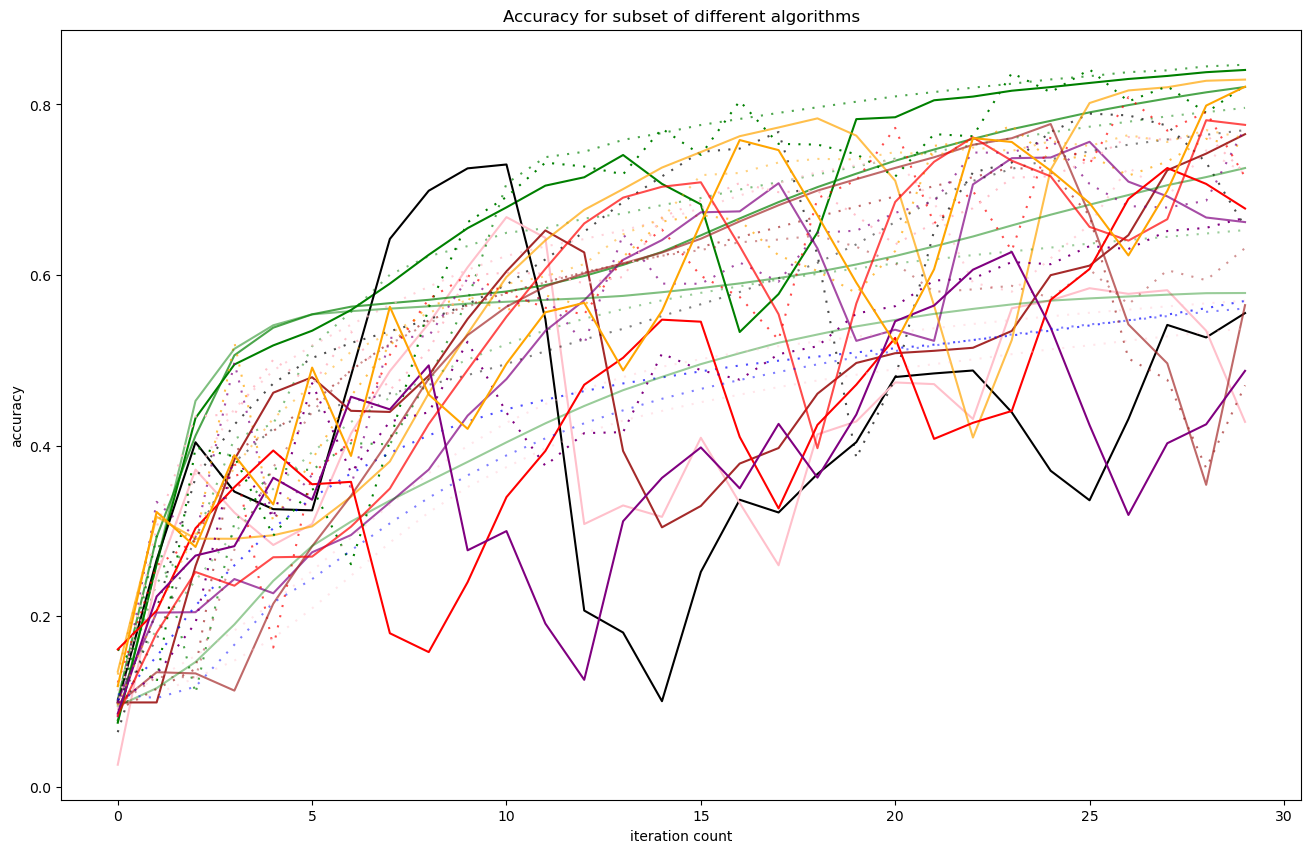

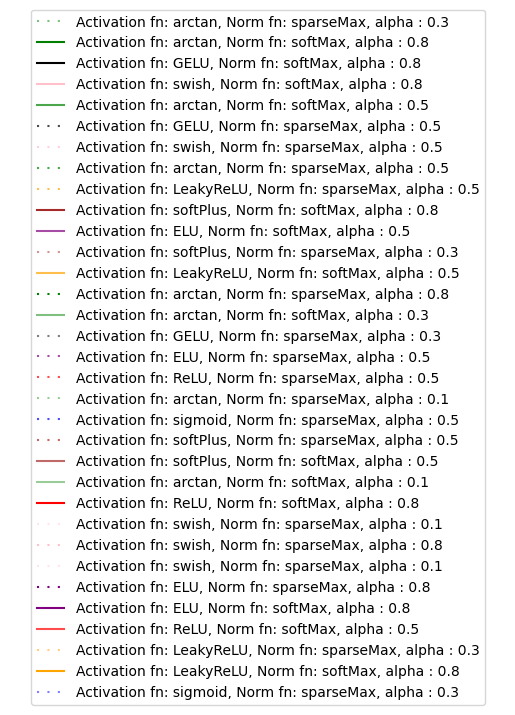

In [47]:
colours = ["red", "blue", "green", "orange", "purple", "black", "pink", "brown"]
lineType = ["-", "--", "-.", ":", (0, (3, 5)), (0, (1, 4))]
brightness = [0.1, 0.2, 0.4, 0.5, 0.7, 1]

# Your main plot
fig, ax = plt.subplots(figsize=(16, 10))  # larger figure

# Separate legend figure

for i in range (len(A)):
    accuracy = A[i][0]
    ax.plot(accuracy[0], accuracy[1], label = "Activation fn: " + A[i][1].__name__ + ", Norm fn: " + A[i][2].__name__ + ", alpha : " + str(A[i][3]), linestyle = lineType[NormalizationFunctions.index(A[i][2])], color = colours[ActivationFunctions.index(A[i][1])], alpha = brightness[alphas.index(A[i][3])])
plt.xlabel("iteration count")
plt.ylabel("accuracy")
plt.title("Accuracy for subset of different algorithms")
plt.savefig('AccuracyPlot_Subset.pdf', dpi=600, bbox_inches='tight')                # vector format, infinitely zoomable


fig_leg = plt.figure()
ax_leg = fig_leg.add_subplot()
ax_leg.axis('off')  # hide axes
ax_leg.legend(*ax.get_legend_handles_labels(), loc='center')
# plt.savefig('figure.png', dpi=300)       # 300 dpi is good for print
plt.savefig('AccuracyLegend_Subset.pdf', dpi=600, bbox_inches='tight')                # vector format, infinitely zoomable
plt.show()

### Future work
only good normalization fns are: sparseMax and softMax
alphas: 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7
Activation functions: arctan, leakyReLU, swish, softPlus, ELU, GELU, ReLU

Redo the first broad testing with every permutation of this:

In [ ]:
ActivationFunctions = [ReLU, sigmoid, arctan, LeakyReLU, ELU, GELU, swish, softPlus]
ActivationDerivatives = [deriv_ReLU, deriv_sigmoid, deriv_arctan, deriv_LeakyReLU, deriv_ELU, deriv_GELU, deriv_swish, deriv_softPlus]
NormalizationFunctions = [softMax, sparseMax]
alphas = [0.1, 0.2, 0.3, 0.5, 0.7]
A = np.empty((len(ActivationFunctions), len(NormalizationFunctions), len(alphas)), dtype=object)

numIterations = 50

for i in range(len(ActivationFunctions)):
    for j in range(len(NormalizationFunctions)):
        for k in range(len(alphas)):
            print("Activation fn: " + ActivationFunctions[i].__name__ + ", Norm fn: " + NormalizationFunctions[j].__name__ + ", a : " + str(alphas[k]))
            _,_,_,_,accuracy = gradient_descent(x_train, y_train, numIterations, alphas[k], ActivationFunctions[i], NormalizationFunctions[j], ActivationDerivatives[i])
            A[i,j,k] = accuracy

In [ ]:
colours = ["red", "blue", "green", "orange", "purple", "black", "pink", "brown"]
lineType = ["-", ":"]
brightness = [0.1, 0.2, 0.5, 0.7, 1]

# Your main plot
fig, ax = plt.subplots(figsize=(16, 10))  # larger figure

# Separate legend figure

for i in range(len(ActivationFunctions)):
    for j in range(len(NormalizationFunctions)):
        for k in range(len(alphas)):
            accuracy = A[i,j,k]
            ax.plot(accuracy[0], accuracy[1], label = "Activation fn: " + ActivationFunctions[i].__name__ + ", Norm fn: " + NormalizationFunctions[j].__name__ + ", alpha : " + str(alphas[k]), linestyle = lineType[j], color = colours[i], alpha = brightness[k])
plt.xlabel("iteration count")
plt.ylabel("accuracy")
plt.title("Accuracy for different algorithms")
plt.savefig('AccuracyPlot_SecondPermutations.pdf', dpi=600, bbox_inches='tight')                # vector format, infinitely zoomable


fig_leg = plt.figure()
ax_leg = fig_leg.add_subplot()
ax_leg.axis('off')  # hide axes
ax_leg.legend(*ax.get_legend_handles_labels(), loc='center')
# plt.savefig('figure.png', dpi=300)       # 300 dpi is good for print
plt.savefig('AccuracyLegend_SecondPermutations.pdf', dpi=600, bbox_inches='tight')                # vector format, infinitely zoomable
plt.show()

In [58]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = x_train[:, index, None]
    prediction = make_predictions(x_train[:, index, None], W1, b1, W2, b2)
    label = y_train[index]
    print("Prediction: ", prediction[0])
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  0
Label:  0


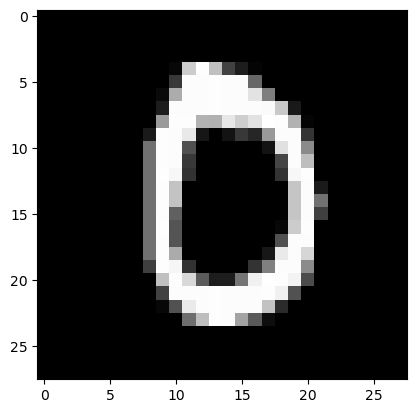

In [66]:
# test_prediction(random.randint(0,m), W1, b1, W2, b2)